In [1]:
path = ""

In [2]:

## UNCOMMENT THIS CELL IF USING GOOGLE COLAB ###

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the path in your Drive..
FOLDERNAME = "Transformer"

assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(f'/content/drive/My Drive/{FOLDERNAME}')

path = f'/content/drive/My Drive/{FOLDERNAME}'

Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

!pip install transformers

import os
import gc
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from utils2 import *
from dataset import *
from model import *
from Scheduler import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.5 MB/s eta 0:00:00
cuda:0


In [4]:
data_folder = "WMT14 EN-GE/"

vocab_folder = os.path.join(data_folder,"vocab")
train_folder = os.path.join(data_folder,"train")
test_folder = os.path.join(data_folder,"test")
mappings_path = os.path.join(data_folder,"dict.en-de")

folders_map = {"train":train_folder,"test":test_folder}

In [5]:
!pip install wget
import wget

for folder in [data_folder, vocab_folder, train_folder, test_folder]:
  if not(os.path.exists(folder)):
    os.mkdir(folder)

urls_to_load = {"https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.en":vocab_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.de":vocab_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en":train_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.en":test_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de":train_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.de":test_folder}  # a list to store the urls

files_namings = {"https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.en":"vocab.en",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.de":"vocab.de",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en":"train.en",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.en":"test.en",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de":"train.de",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.de":"test.de"}

# starting to download
print("Starting downloading")
for url,dir in urls_to_load.items():
    file_name = dir + '/' + files_namings[url] # get the full path to the file
    if not(os.path.exists(file_name)):
     # if doesn't exists, download it.
        file_name = wget.download(url, out=file_name)
        print(file_name)

print("ok")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=228206fce1e3075b023cd79cdebbd657fec325cc4c620ac626611bb20cd354f6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Starting downloading
WMT14 EN-GE/vocab/vocab.en
WMT14 EN-GE/vocab/vocab.de
WMT14 EN-GE/train/train.en
WMT14 EN-GE/test/test.en
WMT14 EN-GE/train/train.de
WMT14 EN-GE/test/test.de
ok


In [6]:
data_map = {"en":{"train":[],"test":[],"val":[]},
             "de":{"train":[],"test":[],"val":[]}}

data_text = extractTextFromFolders(folders_map,data_map,val_split = 0.75, limit = 3e4)

extracting text from folders ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
tokenizer = create_train_bpe_tokenizer(folders_map,data_map, tokenizers_path = os.path.join(path,f"tokenizers"))

True /content/drive/My Drive/Transformer/tokenizers/tokenizer_shared.json
loading pretrained  ..../content/drive/My Drive/Transformer/tokenizers/tokenizer_shared.json


In [8]:
tokenizer.decode(tokenizer.encode_batch(["Hi !", "How are you gneingieinhgeinh ?"],)[1].ids)

'How are you gn ein gi ein h g ein h ?'

In [9]:
data_tokens = extractTokens(data_text,tokenizer)

extracting tokens ...:   0%|          | 0/2 [00:00<?, ?it/s]

214 214
214 214
214 214
214 214


In [10]:
data_encodings = extractEncodings(data_tokens)

extracting encodings ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
print(tokenizer.decode(data_encodings["en"]["train"][5155].tolist()))
print(tokenizer.decode(data_encodings["de"]["train"][5155].tolist()))

We are available from mon day to s atur day from 8 . 30 un til 23 . 00 on + 31 ( 0 ) 38 ## AT ##-## AT ## 33 3 01 01 .
Wir sind von Montag bis Samstag von 08 . 30 bis 23 . 00 Uhr zu erreichen unter Nummer + 49 30 ## AT ##-## AT ## 8 96 77 9 9 19 .


In [12]:
wmt_train = WMT(inpt_encodings=data_encodings["en"]["train"],tgt_encodings=data_encodings["de"]["train"],
                eos_index = tokenizer.token_to_id("[EOS]"), pad_index = tokenizer.token_to_id("[PAD]"))
wmt_val = WMT(inpt_encodings=data_encodings["en"]["val"],tgt_encodings=data_encodings["de"]["val"],
              eos_index = tokenizer.token_to_id("[EOS]"), pad_index = tokenizer.token_to_id("[PAD]"))
wmt_test = WMT(inpt_encodings=data_encodings["en"]["test"],tgt_encodings=data_encodings["de"]["test"],
               eos_index = tokenizer.token_to_id("[EOS]"), pad_index = tokenizer.token_to_id("[PAD]"))

In [13]:
gc.collect()

0

In [14]:
batch_size = 64
trainLoaders = {}

train_dataloader = DataLoader(wmt_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(wmt_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(wmt_test, batch_size=batch_size, shuffle=True)


trainLoaders["train"] = train_dataloader
trainLoaders["val"] = val_dataloader


## Generating an example ##
for i,batch in enumerate(iter(val_dataloader)):

    inputs,targets = batch["input"],batch["target"]
    idx = np.random.randint(0,len(inputs))
    if i < 1:
        print(f"inputs batch shape: {inputs['encodings'].size()}")
        print(f"targets batch shape: {targets['decoder_input_encodings'].size()}")
        sample = (inputs["encodings"][idx],targets["decoder_input_encodings"][idx])
        print(f"encodings : {sample[0]}")
        print(f"masks : {inputs['masks'][idx]}")
        print(f"masks : {inputs['masks'].shape}")
        print(f"masks : {targets['masks'][idx]}")
        print(f"masks : {targets['masks'].shape}")

        print(tokenizer.decode(sample[0].tolist()),"\n",
             tokenizer.decode(sample[1].tolist()))
        break

inputs batch shape: torch.Size([64, 213])
targets batch shape: torch.Size([64, 213])
encodings : tensor([18201,  6627, 22661,  3230,  2758,  3512,  3181,  2862,  6731,  2703,
        13940,  3509,  3236, 21581,    15, 25168,    37,  3214,  2714,  4811,
           17,     6,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,   

In [15]:
model = Transformer(src_vocabSize = tokenizer.get_vocab_size(),
                    tgt_vocabSize = tokenizer.get_vocab_size(),
                    src_max_len = data_encodings["en"]["train"].shape[1],
                    tgt_max_len = data_encodings["de"]["train"].shape[1],
                    noHeads = 8,
                    d_model = 512,
                    d_ff = 2048,
                    dropout = 0.1,
                    noEncoder = 1,
                    noDecoder = 1,
                    pad_index = tokenizer.token_to_id("[PAD]"),
                   device = device).to(device)

for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [16]:
optimizer = torch.optim.Adam(model.parameters(),
                             betas = (0.9, 0.98),
                              eps = 1.0e-9)

In [17]:
scheduler = Scheduler(optimizer =  optimizer,
                 dim_embed= 512,
                 warmup_steps=400)

In [18]:
print(f"Numeber of the model's trainable paramaters : {count_parameters(model)}")


Numeber of the model's trainable paramaters : 38101296


In [19]:
## An example of the untrained model prediction ##

out = model(wmt_train[4:5]["input"], wmt_train[4:5]["target"])
print(out.shape)

print(f"True label : {tokenizer.decode(wmt_train[4:5]['target']['target_encodings'][0].tolist())}")
print(f"Prediction : {tokenizer.decode(torch.argmax(out,2)[0].tolist())}")

## The prediction loss ##
loss = translationLoss(output=out, target=wmt_train[:1]["target"]["target_encodings"].to(device), pad_index = tokenizer.token_to_id("[PAD]"), label_smoothing = 0.1)
print(loss)

torch.Size([1, 213, 30000])
True label : die Mitteilungen sollen den geschäftlichen kommerziellen Charakter tragen .
Prediction : Adresse Mitteilungen Verschlüssel velop Place funk kulturellen Beauty weisen Beauty bibliothe License Beauty kulturellen zusammenzuarbeiten Beauty kulturellen funk Beauty License License näch License funk Rass funk Hell Verständnis Hell wünschenswert näch räder Verschlüssel Place schmack funk gt gt ianer näch agd Verfahrens 卓 Austausch gt verschließen näch näch License näch Hell näch Instal zusammenzuarbeiten License kulturellen License näch näch Verfahrens License Place festhalten zusammenzuarbeiten License ari zusammenzuarbeiten License License Arch zusammenzuarbeiten zusammenzuarbeiten zusammenzuarbeiten License Verfahrens zusammenzuarbeiten BMW Radar Verfahrens Gemälde License festhalten 可 funk funk 页 ianer ake zusammenzuarbeiten nö keinem Radar solches näch näch 卓 Verfahrens zusammenzuarbeiten uen pré technische Verfahrens Verfahrens wünschenswert wünsc

In [20]:
if not (os.path.exists("trained")):
        os.mkdir("trained")

filename = "transformer-weights-small"

In [21]:
train_cum_losses, val_cum_losses = [], []

In [22]:
trainedModel, train_losses, val_losses = train_model(model, trainLoaders, translationLoss, optimizer,
                           pad_index = tokenizer.token_to_id("[PAD]"), label_smoothing = 0.1,
                           scheduler = scheduler, num_epochs=20, device = device, isSave=True,
                           filename = filename, verbose = False)

train_cum_losses += train_losses
val_cum_losses += val_losses

torch.save(model.state_dict(), f"trained/{filename}")
!cp -r './trained/transformer-weights-small' /content/drive/MyDrive/

Epoch 0/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 0
train current epoch Loss: 14.522197487679394, lr = 0.0019500679199910256


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 0
val current epoch Loss: 13.150054705345024, lr = 0.0019500679199910256
Epoch 1/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 14.522197487679394
train current epoch Loss: 12.105187833309174, lr = 0.0016644488790353359


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 13.150054705345024
val current epoch Loss: 12.578696186259641, lr = 0.0016644488790353359
Epoch 2/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 12.105187833309174
train current epoch Loss: 10.982149736447768, lr = 0.0013593382134073615


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.578696186259641
val current epoch Loss: 12.344071768097958, lr = 0.0013593382134073615
Epoch 3/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 10.982149736447768
train current epoch Loss: 10.192465069619091, lr = 0.0011773606671386621


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.344071768097958
val current epoch Loss: 12.262963981951698, lr = 0.0011773606671386621
Epoch 4/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 10.192465069619091
train current epoch Loss: 9.58192343603481, lr = 0.001053138140613131


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.262963981951698
val current epoch Loss: 12.28715798814418, lr = 0.001053138140613131
Epoch 5/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 9.58192343603481
train current epoch Loss: 9.081290293823589, lr = 0.000961424690200249


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.28715798814418
val current epoch Loss: 12.344162350994045, lr = 0.000961424690200249
Epoch 6/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 9.081290293823589
train current epoch Loss: 8.665514534169978, lr = 0.0008901363935873205


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.344162350994045
val current epoch Loss: 12.415547282008802, lr = 0.0008901363935873205
Epoch 7/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 8.665514534169978
train current epoch Loss: 8.313445821404457, lr = 0.0008326674656014912


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.415547282008802
val current epoch Loss: 12.432000725956286, lr = 0.0008326674656014912
Epoch 8/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 8.313445821404457
train current epoch Loss: 8.008500000292605, lr = 0.0007850618979762994


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.432000725956286
val current epoch Loss: 12.483578803175586, lr = 0.0007850618979762994
Epoch 9/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 8.008500000292605
train current epoch Loss: 7.74645839089697, lr = 0.0007447868617724812


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.483578803175586
val current epoch Loss: 12.551602929325426, lr = 0.0007447868617724812
Epoch 10/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 7.74645839089697
train current epoch Loss: 7.509866630489176, lr = 0.0007101355772556199


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.551602929325426
val current epoch Loss: 12.629837165444584, lr = 0.0007101355772556199
Epoch 11/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 7.509866630489176
train current epoch Loss: 7.297879498113286, lr = 0.0006799103665255266


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.629837165444584
val current epoch Loss: 12.67400863615133, lr = 0.0006799103665255266
Epoch 12/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 7.297879498113286
train current epoch Loss: 7.1133258451115005, lr = 0.0006532426971741857


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.67400863615133
val current epoch Loss: 12.776891950833596, lr = 0.0006532426971741857
Epoch 13/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 7.1133258451115005
train current epoch Loss: 6.944337922063741, lr = 0.0006294853256494173


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.776891950833596
val current epoch Loss: 12.807106494903564, lr = 0.0006294853256494173
Epoch 14/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 6.944337922063741
train current epoch Loss: 6.786459825255654, lr = 0.0006081447133912101


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.807106494903564
val current epoch Loss: 12.860229678073171, lr = 0.0006081447133912101
Epoch 15/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 6.786459825255654
train current epoch Loss: 6.647879150780764, lr = 0.0005888370711803363


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.860229678073171
val current epoch Loss: 12.912498231661521, lr = 0.0005888370711803363
Epoch 16/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 6.647879150780764
train current epoch Loss: 6.522138504819437, lr = 0.0005712588511532102


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.912498231661521
val current epoch Loss: 12.991847167580815, lr = 0.0005712588511532102
Epoch 17/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 6.522138504819437
train current epoch Loss: 6.403046467087486, lr = 0.0005551663900922162


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 12.991847167580815
val current epoch Loss: 13.020186836436643, lr = 0.0005551663900922162
Epoch 18/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 6.403046467087486
train current epoch Loss: 6.296284804289991, lr = 0.0005403615285637954


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 13.020186836436643
val current epoch Loss: 13.078462253182622, lr = 0.0005403615285637954
Epoch 19/19
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 6.296284804289991
train current epoch Loss: 6.196692638776519, lr = 0.0005266812375397702


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 13.078462253182622
val current epoch Loss: 13.11369613065558, lr = 0.0005266812375397702

Training complete in 85m 2s
Best val loss: 12.262964


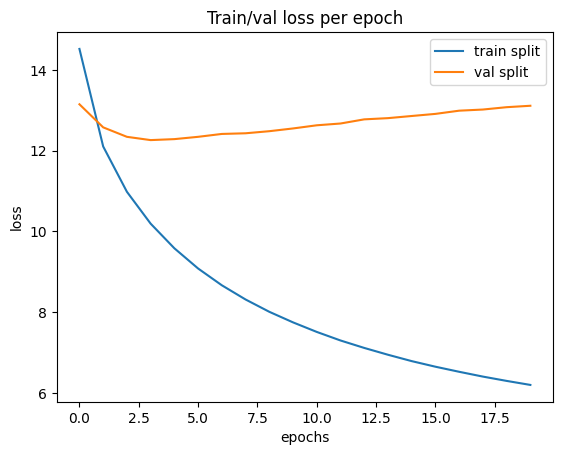

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(len(train_cum_losses)), train_cum_losses, label = 'train split')
ax.plot(np.arange(len(val_cum_losses)), val_cum_losses, label = "val split")

ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_title("Train/val loss per epoch")
ax.legend()

plt.show()

In [28]:
results = evaluate_model(model, train_dataloader, tokenizer, device = device)

Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

 Result : 0.1356075406074524

Evaluating complete in 1m 32s


In [ ]:
model.load_state_dict(torch.load(os.path.join(path,os.path.join("trained",filename))))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [29]:
for i,batch in enumerate(iter(train_dataloader)):

    inputs,targets = batch["input"],batch["target"]
    idx = np.random.randint(0,len(inputs))
    if i < 1:
        print(f"inputs batch shape: {inputs['encodings'].size()}")
        print(f"targets batch shape: {targets['decoder_input_encodings'].size()}")
        sample = (inputs["encodings"][0],targets["decoder_input_encodings"][0])

        print(f"Input English Sentence : {tokenizer.decode(sample[0].tolist())}")
        print(f"Input German Sentence (Translated) : {tokenizer.decode(sample[1].tolist())}")

        out = model(inputs, targets)
        print(out.shape)

        print(f"Predicted German Sentence (Translated) : {tokenizer.decode(torch.argmax(out[idx],1).tolist())}")

        loss = translationLoss(output = out, target = targets['target_encodings'].to(device), pad_index = tokenizer.token_to_id("[PAD]"), label_smoothing = 0.1)
        print(loss)

        bleu_score = score(out, targets, tokenizer, kind = "bleu")
        print(bleu_score)

        break



inputs batch shape: torch.Size([64, 213])
targets batch shape: torch.Size([64, 213])
Input English Sentence : Bel ize , &# 91 ; 1 &# 93 ; form er ly the col ony of British H ond uras , is the only coun try in Central America without a co ast line on the Pac ific O cean ( only the C ari b bean Sea to its e ast ) , and the only one in the region with English as its off ic ial language .
Input German Sentence (Translated) : Bel ize , die ehemalige britische Kolonie “ Bri tisch H ond uras ” , ist das bevölker ungs ärm ste Land und eines der kleinsten Länder ( nur wenig größer als H essen ) in Mittel amerika und grenzt im Norden an Mexiko und im Westen und Süden an Guatemala . Bel ize ist das einzige Land Mittel amerikas , das keinen Zugang zum Pazifik hat .
torch.Size([64, 213, 30000])
Predicted German Sentence (Translated) : DC UN IV ER SE und alle auf den Zusammenhang stehenden DC und Elemente sind Handels marken von Handels © DC Com ics . . und und © und und und und und und und sind und

In [ ]:
# !cp -r './trained/transformer-weights' /content/drive/MyDrive/

In [ ]:
infer(model.to(device), "hi, how are you.", tokenizer, device = device)